In [2]:
from google.colab import files
files.upload()
!pip install -q kaggle

Saving kaggle.json to kaggle.json


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d franciscofeng/augmented-china-stock-data-with-fundamentals
!unzip augmented-china-stock-data-with-fundamentals.zip -d data/

 97% 445M/459M [00:02<00:00, 213MB/s]
100% 459M/459M [00:02<00:00, 168MB/s]
Archive:  augmented-china-stock-data-with-fundamentals.zip
  inflating: data/stock_data.csv     
  inflating: data/ticker_info.csv    


In [4]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt
import datetime as dt

## Reading data

In [5]:
china_stocks = pd.read_csv("data/stock_data.csv")
ticker_info = pd.read_csv("data/ticker_info.csv")
china_stocks['date'] = pd.to_datetime(china_stocks['date'])

In [28]:
def creating_df(ticker: str):
  df = china_stocks.loc[china_stocks['ticker'] == ticker]
  df = df.loc[:,['date', 'open', 'high', 'low', 'close', 'volume']]
  
  df['date1'] = df['date']
  df.set_index('date', inplace=True)
  df.index.names = ['time']
  df = df.rename(columns={'date1': 'date'})

  df['date'] = df['date'].apply(mpl_dates.date2num)

  return df

In [29]:
df = creating_df('sh600114')
df.head()

,open,high,low,close,volume,date
time,,,,,,
2005-01-04,1.51,1.59,1.50,1.56,1337996.0,731950.0
2005-01-05,1.55,1.57,1.54,1.56,553559.0,731951.0
2005-01-06,1.57,1.59,1.55,1.55,650605.0,731952.0
2005-01-07,1.54,1.59,1.54,1.55,539820.0,731953.0
2005-01-10,1.56,1.57,1.54,1.55,298500.0,731956.0


## Adding support and resistance dates to the dataframe

In [30]:
def add_sup_res(data):
  data['support'] = np.nan
  data['resistance'] = np.nan

  # if price falls 5 days in a row
  data.loc[(data['low'].shift(5) > data['low'].shift(4))&
        (data['low'].shift(4) > data['low'].shift(3))&
        (data['low'].shift(3) > data['low'].shift(2))&
        (data['low'].shift(2) > data['low'].shift(1))&
        (data['low'].shift(1) > data['low'].shift(0)), 'support'] = data['low']

  # if price rises 5 days in a row
  data.loc[(data['high'].shift(5) < data['high'].shift(4))&
        (data['high'].shift(4) < data['high'].shift(3))&
        (data['high'].shift(3) < data['high'].shift(2))&
        (data['high'].shift(2) < data['high'].shift(1))&
        (data['high'].shift(1) < data['high'].shift(0)), 'resistance'] = data['high']
  
  return data

In [31]:
df = add_sup_res(df)

In [32]:
fig = go.Figure(data=[go.Candlestick(
                x=df.index,
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'],
                name='sh600114')])

support_line = go.Scatter(x=df.index,
                          y=df['support'].fillna(method='ffill'),
                          mode='lines',
                          line=dict(color='#CE5757', width=3, dash='dot'),
                          name='support')

resistance_line = go.Scatter(x=df.index,
                             y=df['resistance'].fillna(method='ffill'),
                             mode='lines',
                             line=dict(color='#57CE95', width=3, dash='dot'),
                             name='resistance')

fig.add_trace(support_line)
fig.add_trace(resistance_line)

fig.show()

## Adding signals for buying and selling assets to the dataframe


In [33]:
def add_signals(data):
  data['signal'] = 0

  data['resistance'] = data['resistance'].fillna(method='ffill')
  data['support'] = data['support'].fillna(method='ffill')

  condition_buy = (data['close'].shift(1) < data['resistance'].shift(1)) & (data['close'] > data['resistance'])
  condition_sell = (data['close'].shift(1) > data['support'].shift(1)) & (data['close'] < data['support'])

  data.loc[condition_buy, 'signal'] = 1
  data.loc[condition_sell, 'signal'] = -1

  return data

## Backtest on all available dates

In [34]:
# here I calculate annualised Sharpe. 252 - trading periods in year
def calc_sharp_romadd(data):
  sharpe_ratio = np.sqrt(252) * (data - 0.05 / 252).mean() / data.std()
  # sharpe_ratio = data.cumsum().mean() / data.cumsum().std()
  romadd = np.abs(data.cumsum().max() / np.nanmin(data.replace(0, np.nan).values))
  print(f'Sharpe ratio: {sharpe_ratio}')
  print(f'Return over max drawdown: {romadd}')

Sharpe ratio: -0.07332318076772051
Return over max drawdown: 3.5809432996590043


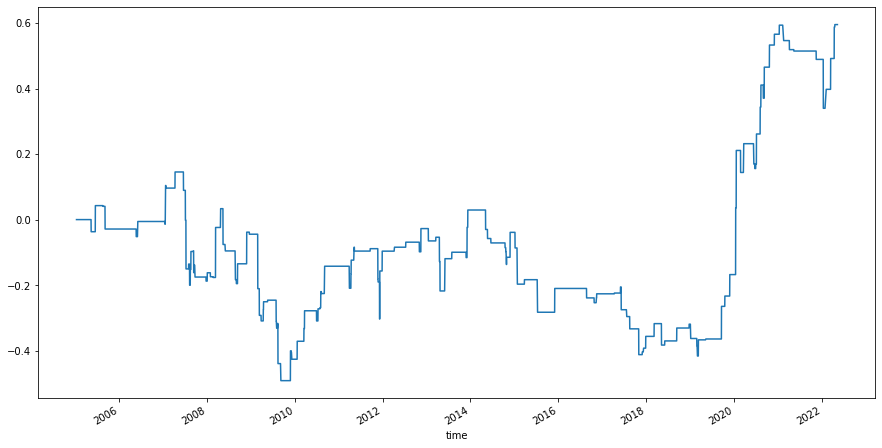

In [35]:
# all-time yield with a rate of 5 days
df = add_signals(df)
duration = 5

df['pct'] = df['close'].pct_change(1)

df['return'] = np.array([df['pct'].shift(i) for i in range(duration)]).sum(axis=0) * df['signal'].shift(duration)

df['return'].cumsum().plot(figsize=(15, 8))

calc_sharp_romadd(df['return'])

## Final calculation for 2022

In [36]:
def get_results_on_final(data):
  duration = 5

  data['pct'] = data['close'].pct_change(1)
  
  data['return'] = np.array([data['pct'].shift(i) for i in range(duration)]).sum(axis=0) * data['signal'].shift(duration)
  
  df_tmp = data.loc[dt.datetime(2022, 1, 1) : dt.datetime(2022, 5, 11)]
  
  return df_tmp

Sharpe ratio: 0.7505565818848824
Return over max drawdown: 0.7119731812237112


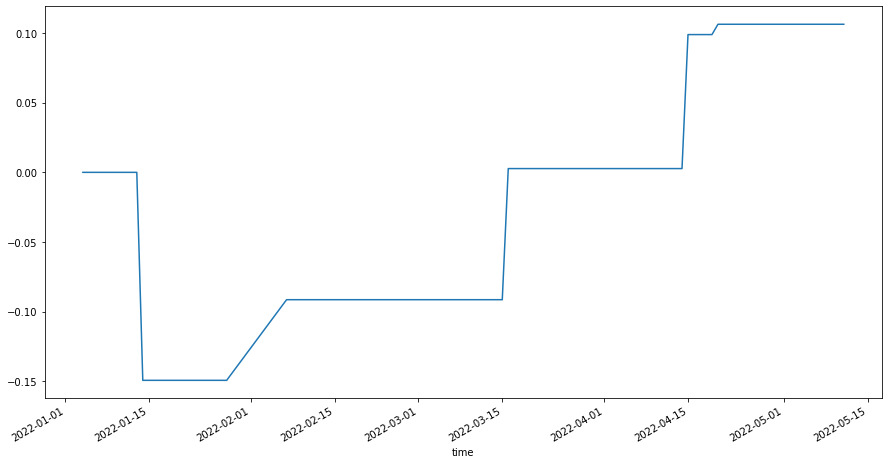

In [37]:
final = get_results_on_final(df)
final['return'].cumsum().plot(figsize=(15, 8))
calc_sharp_romadd(final['return'])

## Now diversify

Here I take 5 different assets and calculate the average return from them. This is similar to the situation if we put the same amount of money into each.


In [38]:
tickers_to_diversify = ['sh600000', 'sh600114', 'sz300188', 'sz000935', 'sz000034']

Sharpe ratio: 2.8990816579961374
Return over max drawdown: 5.242668658240779


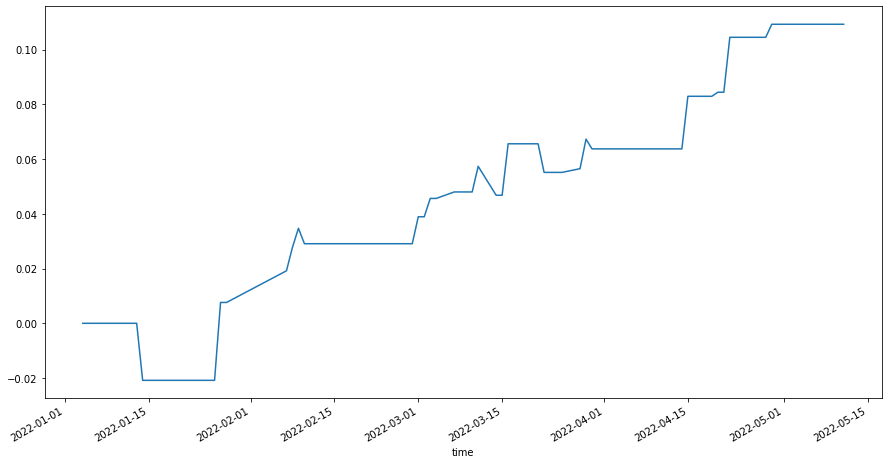

In [39]:
results = 0
for i in tickers_to_diversify:
  df = creating_df(i)
  df = add_sup_res(df)
  df = add_signals(df)
  df = get_results_on_final(df)
  results += df['return']

# I divide by 5 because there are 5 assets
results /= 5
results.cumsum().plot(figsize=(15, 8))

calc_sharp_romadd(results)

## Trying to improve strategy

In [40]:
def add_signals_new(data):
  data['signal'] = 0

  data['resistance'] = data['resistance'].fillna(method='ffill')
  data['support'] = data['support'].fillna(method='ffill')

  # here I changed that we are waiting for 1 more day after breaking thgough support or resistance
  condition_buy = (data['close'].shift(2) < data['resistance'].shift(2)) & (data['close'].shift(1) > data['resistance'].shift(1)) & (data['close'] > data['resistance'])
  condition_sell = (data['close'].shift(2) > data['support'].shift(2)) & (data['close'].shift(1) < data['support'].shift(1)) & (data['close'] < data['support'])

  data.loc[condition_buy, 'signal'] = 1
  data.loc[condition_sell, 'signal'] = -1

  return data

#### Indicators have increased significantly for ticker 'sh600114' :

Sharpe ratio: 2.1661334275656503
Return over max drawdown: 2.7655406139540033


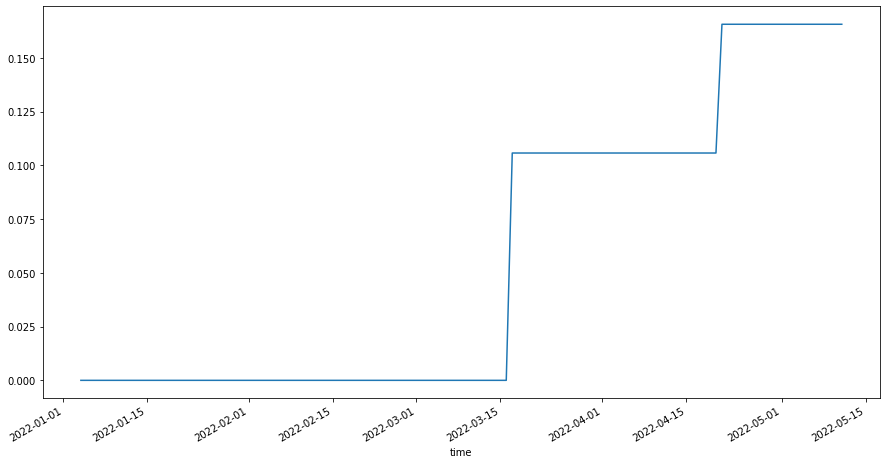

In [41]:
df = creating_df('sh600114')
df = add_sup_res(df)
df = add_signals_new(df)
df = get_results_on_final(df)

df['return'].cumsum().plot(figsize=(15, 8))
calc_sharp_romadd(df['return'])

## What will happen to our diversified assets?

Sharpe ratio: 1.0232640473008199
Return over max drawdown: 3.1748157369978554


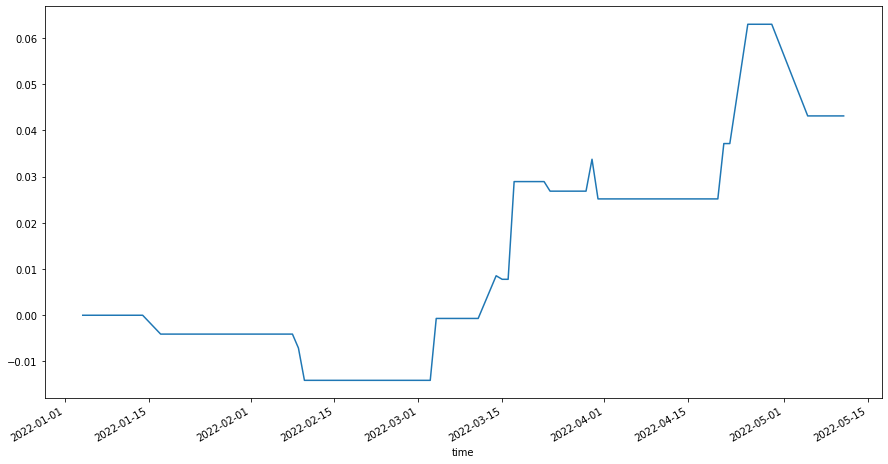

In [42]:
tickers_to_diversify = ['sh600000', 'sh600114', 'sz300188', 'sz000935', 'sz000034']
results = 0
for i in tickers_to_diversify:
  df = creating_df(i)
  df = add_sup_res(df)
  df = add_signals_new(df)
  df = get_results_on_final(df)
  results += df['return']

# I divide by 5 because there are 5 assets
results /= 5
results.cumsum().plot(figsize=(15, 8))

calc_sharp_romadd(results)

### It only got worse. We need to come up with something else.